In [1]:
import healpy as hp
import numpy as np

In [2]:
import numpy.ma as ma

In [3]:
%matplotlib inline

In [4]:
#from glob import glob
from matplotlib import pyplot as plt

In [5]:
import pandas as pd
import quaternionarray as qa
from mapmaking import pix2map

In [108]:
import healpy as hp
import numpy as np
NSIDE = 128
DAYS = 29

In [111]:
#the comments in this are for my benefit, and  are not necessary to go through, you can skip to the next section 
#for more pertinant findings
for LOCATION in ["Greenland"]:

    for OPENING_ANGLE in [40]:
        hit = hp.ma(np.zeros(hp.nside2npix(NSIDE)))
        for day in range(29, DAYS + 1):

            print(day)
            
            #load the zenith and north pointing information
            pointing = pd.read_hdf("zenith_pointing_%s.h5" % LOCATION.lower(), "data")["2015-08-%02d" % day]

            #create a unit vectors of theta/phi zenith directions from pointing, then take transpose
            vec = hp.dir2vec(
                             np.degrees(pointing.ra_zenith_rad), 
                             np.degrees(pointing.dec_zenith_rad), lonlat=True).T

            #create a unit vectors of theta/phi north directions from pointing, then take transpose
            vec_north = hp.dir2vec(
                             np.degrees(pointing.ra_north_rad), 
                             np.degrees(pointing.dec_north_rad), lonlat=True).T

            x = np.array([1,0,0])
            y = np.array([0,1,0])
            z = np.array([0,0,1])

            #I don't think this line affects the code at all
            vec_north.T[:,0][:,np.newaxis]

            #create lon/lat angles from xyz coordinates
            lon, lat= hp.vec2dir(vec[:,0], vec[:,1], vec[:,2], lonlat=True)

            #create empty array of dimensions len(vec)x4
            q = np.empty([len(vec), 4], dtype=np.float)
            

            # `rotmat` / `q` are the rotation matrix / quaternion between the local system and Equatorial coordinates
            n = len(vec)
            for i in range(n):
                #create a 3x3 rotations matrix by stacking, *need to understand this better*
                
                rotmat = np.hstack([ vec_north[i,:][:,np.newaxis],
                                     np.cross(vec[i,:], vec_north[i,:])[:,np.newaxis],
                                     vec[i,:][:,np.newaxis]
                                ])
            
                
                #from_rotmat returns a 4d array with elements set by some funny quaternion math, *need to understand this better*
                #norm() just normalizes
                #if statement insures that all dot products between array elements are positive
                q[i] = qa.norm(qa.from_rotmat(rotmat))
                if (i > 0):
                    if np.dot(q[i], q[i-1]) < 0:
                        q[i] *= -1
'''      
            #list of julian dates for coordinates provided by pointing
            jd = pointing.index.to_julian_date()
            
            #hours since starting time
            ut_h = (jd - jd[0])*24
                

            #create array from 0 to end time, step size is per second, per sampling frequency
            target_ut_h = np.arange(0, ut_h[-1], 1/30./3600.)
           
            # given the values of q at ut_h[i] interpolate values of q at target_ut_h[i]
            qfull = qa.nlerp(target_ut_h, ut_h, q)

            #rotate normalized quaternions of angles OPENING_ANGLE around y axis
            q_elev = qa.rotation(y, np.radians(OPENING_ANGLE))
            
            rotation_speed = np.radians(-1 * 360/60)
            
            #not sure why we want the remainder here, should it be divided by 2pi ?
            az = rotation_speed * (target_ut_h * 3600.) % (2*np.pi)

            #rotate quaternions by az about z axis
            q_rotation = qa.rotation(z, az)

            #rotate about z axis, with angle given by q * (q_rotation * q_elevation)
            direction = qa.rotate(
            qa.mult(qfull, qa.mult(q_rotation, q_elev)),
                    z)
            #direction = qa.rotate(
            #qa.mult(q, qa.mult(q_rotation, q_elev)),
            #        z)
            
            #create lon/lat angles from xyz coordinates of quaternion * angles
            lon, lat= hp.vec2dir(direction[:,0], direction[:,1], direction[:,2], lonlat=True)
            
            #pixel pointed to by vector
                        
            pix = hp.vec2pix(NSIDE,direction[:,0], direction[:,1], direction[:,2] )
            
            #add a hit at different pixel locations on map
            
            hit += hp.ma(pix2map(pix, NSIDE))
hit.mask = hit == 0


'''

29


'      \n            #list of julian dates for coordinates provided by pointing\n            jd = pointing.index.to_julian_date()\n            \n            #hours since starting time\n            ut_h = (jd - jd[0])*24\n                \n\n            #create array from 0 to end time, step size is per second, per sampling frequency\n            target_ut_h = np.arange(0, ut_h[-1], 1/30./3600.)\n           \n            # given the values of q at ut_h[i] interpolate values of q at target_ut_h[i]\n            qfull = qa.nlerp(target_ut_h, ut_h, q)\n\n            #rotate normalized quaternions of angles OPENING_ANGLE around y axis\n            q_elev = qa.rotation(y, np.radians(OPENING_ANGLE))\n            \n            rotation_speed = np.radians(-1 * 360/60)\n            \n            #not sure why we want the remainder here, should it be divided by 2pi ?\n            az = rotation_speed * (target_ut_h * 3600.) % (2*np.pi)\n\n            #rotate quaternions by az about z axis\n        

In [ ]:
'''
I do not think this is the source of the problem but I am not sure that this line is correct:
    az = rotation_speed * (target_ut_h * 3600.) % (2*np.pi) : line 153 in your code
                                                ^                            
Why would we want the remainder here? should it be:
    az = rotation_speed * (target_ut_h * 3600.) / (2*np.pi)
                                                ^
'''

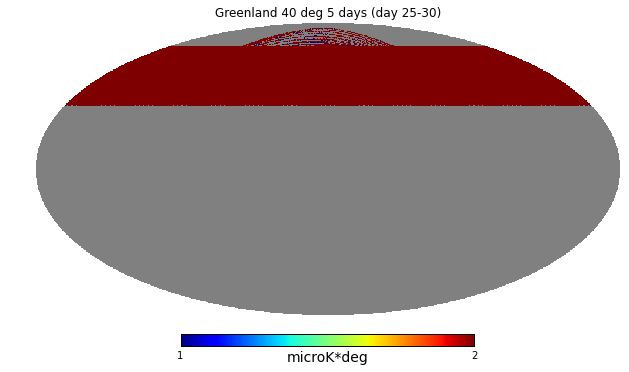

In [81]:
#day 25-30
hp.mollview(hit, xsize = 1000, min = 1, max = 2, unit="microK*deg", title="Greenland 40 deg 5 days (day 25-30)")

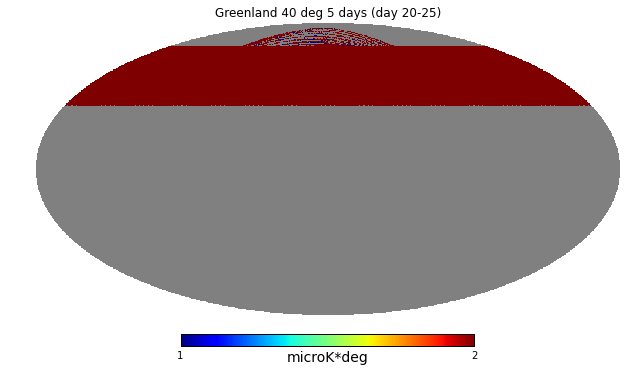

In [85]:
#day 20-25
hp.mollview(hit, xsize = 1000, min = 1, max = 2, unit="microK*deg", title="Greenland 40 deg 5 days (day 20-25)")

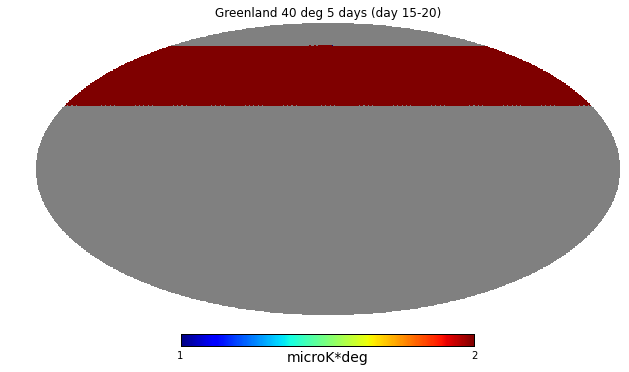

In [88]:
#day 15-20
hp.mollview(hit, xsize = 1000, min = 1, max = 2, unit="microK*deg", title="Greenland 40 deg 5 days (day 15-20)")

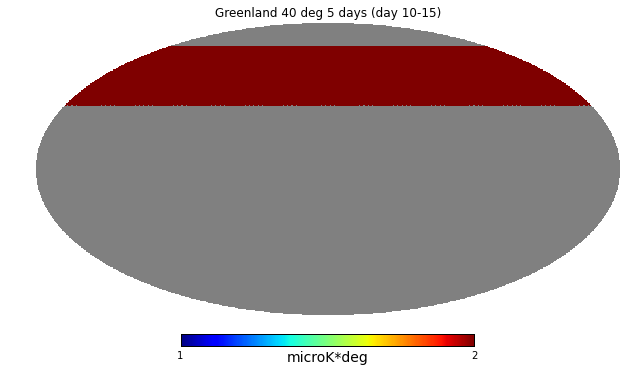

In [110]:
#day 10-15
hp.mollview(hit, xsize = 1000, min = 1, max = 2, unit="microK*deg", title="Greenland 40 deg 5 days (day 10-15)")

In [12]:
#The interpolation error seems to only occus after enough days have passed. i.e. you have to get to ~ day 20 or more to see it
#If you have to0 few days there arent enough hits to see, however given a five day interval the issue
#only arises after a certain amount of days have passed

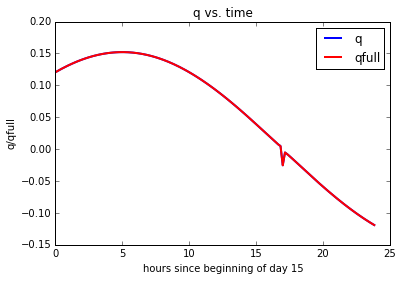

In [39]:
#check the accuracy of the interpolation for day 15
q0, = plt.plot(ut_h, q[:, 0], 'b-', linewidth = 2)
q_interp, = plt.plot(target_ut_h, qfull[:, 0], 'r-', linewidth = 2)
plt.legend([q0, q_interp], ["q", "qfull"], loc = 'upper right')
plt.xlabel("hours since beginning of day 15")
plt.ylabel("q/qfull")
plt.title("q vs. time")
plt.show()
#plt.savefig("../data/hitmaps/debug/qvsTime.png", facecolor = 'w', transparent = False)

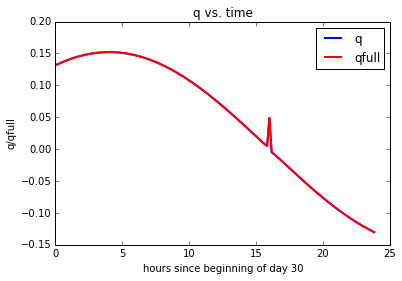

In [58]:
#check the accuracy of the interpolation for day 30
q0, = plt.plot(ut_h, q[:, 0], 'b-', linewidth = 2)
q_interp, = plt.plot(target_ut_h, qfull[:, 0], 'r-', linewidth = 2)
plt.legend([q0, q_interp], ["q", "qfull"], loc = 'upper right')
plt.xlabel("hours since beginning of day 30")
plt.ylabel("q/qfull")
plt.title("q vs. time")
plt.show()
#plt.savefig("../data/hitmaps/debug/qvsTime.png", facecolor = 'w', transparent = False)

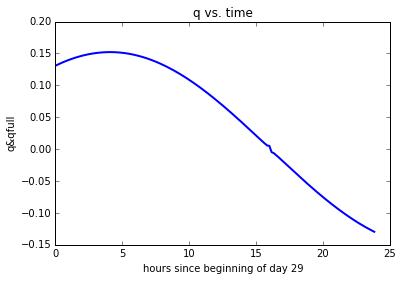

In [113]:
#check the where the spike changes shape
q0, = plt.plot(ut_h, q[:, 0], 'b-', linewidth = 2)
plt.xlabel("hours since beginning of day 29")
plt.ylabel("q&qfull")
plt.title("q vs. time")
plt.show()
#plt.savefig("../data/hitmaps/debug/qvsTime.png", facecolor = 'w', transparent = False)

In [ ]:
'''
you can see that the interpolations are perfect at both 15 and 30 days, however there is a discontinuity in the data
which flips sign between 15 and 30 days, this leads me to beleive that there is an issue with the initial
quaterionions, not the interpolation. This could also explain why we notice the bug in the hit maps for later days,
as the earlier days have the bug, it is just covered up by the other hits.
'''

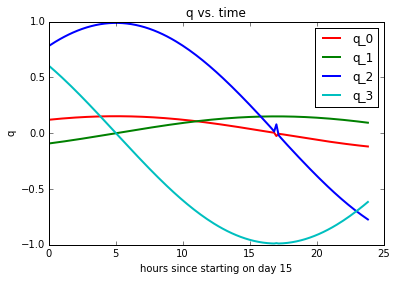

In [40]:
#check all quaternion components on day 15
q0, = plt.plot(ut_h, q[:, 0], 'r-', linewidth = 2)
q1, = plt.plot(ut_h, q[:, 1], 'g-', linewidth = 2)
q2, = plt.plot(ut_h, q[:, 2], 'b-', linewidth = 2)
q3, = plt.plot(ut_h, q[:, 3], 'c-', linewidth = 2)
plt.legend([q0, q1, q2, q3], ["q_0", "q_1", "q_2", "q_3"], loc = 'upper right')
plt.xlabel("hours since starting on day 15")
plt.ylabel("q")
plt.title("q vs. time")
plt.show()
#plt.savefig("../data/hitmaps/debug/qvsTime.png")

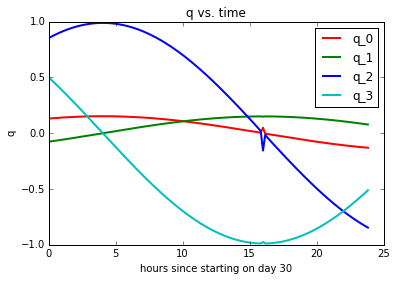

In [43]:
#check all quaternion components on day 30
q0, = plt.plot(ut_h, q[:, 0], 'r-', linewidth = 2)
q1, = plt.plot(ut_h, q[:, 1], 'g-', linewidth = 2)
q2, = plt.plot(ut_h, q[:, 2], 'b-', linewidth = 2)
q3, = plt.plot(ut_h, q[:, 3], 'c-', linewidth = 2)
plt.legend([q0, q1, q2, q3], ["q_0", "q_1", "q_2", "q_3"], loc = 'upper right')
plt.xlabel("hours since starting on day 30")
plt.ylabel("q")
plt.title("q vs. time")
plt.show()
#plt.savefig("../data/hitmaps/debug/qvsTime.png")

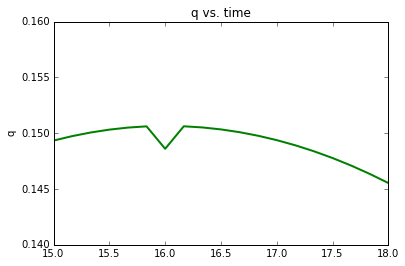

In [103]:
#zoomed in on q_1 to see that the spike is in fact present in all components
q1, = plt.plot(ut_h, q[:, 1], 'g-', linewidth = 2)
plt.ylabel("q")
plt.title("q vs. time")
plt.xlim(15,18)
plt.ylim(.14, .16)
plt.show()
#plt.savefig("../data/hitmaps/debug/q1vsTime.png")

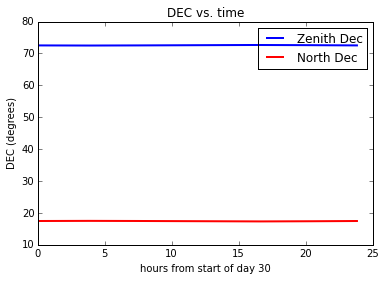

In [10]:
#next I check the pointing information to ensure that the spike is not coming from the initial file

#Check the dec pointing information for day 30
dec_zenith, = plt.plot(ut_h, np.degrees(pointing.dec_zenith_rad), 'b-', linewidth = 2)
dec_north, = plt.plot(ut_h, np.degrees(pointing.dec_north_rad), 'r-', linewidth = 2)
plt.legend([dec_zenith, dec_north], ["Zenith Dec", "North Dec"], loc = 'upper right')
plt.xlabel("hours from start of day 30")
plt.ylabel("DEC (degrees)")
plt.title("DEC vs. time")
plt.show()
#plt.savefig("../data/hitmaps/debug/DecvsTime.png")

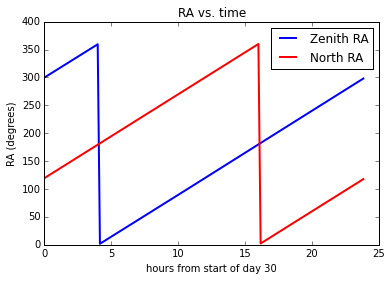

In [11]:
##Check the ra pointing information for day 30
ra_zenith, = plt.plot(ut_h, np.degrees(pointing.ra_zenith_rad), 'b-', linewidth = 2)
ra_north, = plt.plot(ut_h, np.degrees(pointing.ra_north_rad), 'r-', linewidth = 2)
plt.legend([ra_zenith, ra_north], ["Zenith RA", "North RA"], loc = 'upper right')
plt.xlabel("hours from start of day 30")
plt.ylabel("RA (degrees)")
plt.title("RA vs. time")
plt.show()
#plt.savefig("../data/hitmaps/debug/RAvsTime.png")

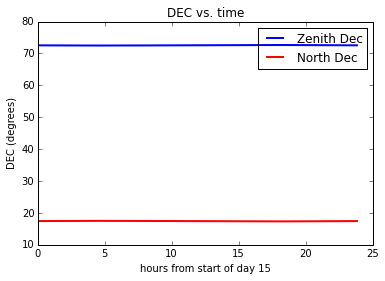

In [25]:
#next I check the pointing information to ensure that the spike is not coming from the initial file

#Check the dec pointing information for day 15
dec_zenith, = plt.plot(ut_h, np.degrees(pointing.dec_zenith_rad), 'b-', linewidth = 2)
dec_north, = plt.plot(ut_h, np.degrees(pointing.dec_north_rad), 'r-', linewidth = 2)
plt.legend([dec_zenith, dec_north], ["Zenith Dec", "North Dec"], loc = 'upper right')
plt.xlabel("hours from start of day 15")
plt.ylabel("DEC (degrees)")
plt.title("DEC vs. time")
plt.show()
#plt.savefig("../data/hitmaps/debug/DecvsTime.png")

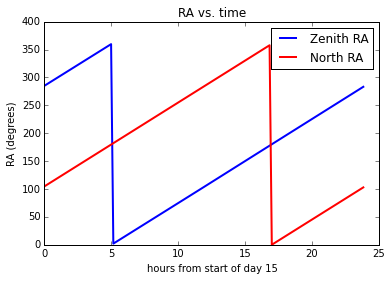

In [33]:
##Check the ra pointing information for day 15
ra_zenith, = plt.plot(ut_h, np.degrees(pointing.ra_zenith_rad), 'b-', linewidth = 2)
ra_north, = plt.plot(ut_h, np.degrees(pointing.ra_north_rad), 'r-', linewidth = 2)
plt.legend([ra_zenith, ra_north], ["Zenith RA", "North RA"], loc = 'upper right')
plt.xlabel("hours from start of day 15")
plt.ylabel("RA (degrees)")
plt.title("RA vs. time")
plt.show()
#plt.savefig("../data/hitmaps/debug/RAvsTime.png")

In [ ]:
'''
This leads me to believe that the problem lies somewhere in the following chunk of code:

n = len(vec)
            for i in range(n):                
                rotmat = np.hstack([ vec_north[i,:][:,np.newaxis],
                                     np.cross(vec[i,:], vec_north[i,:])[:,np.newaxis],
                                     vec[i,:][:,np.newaxis]
                                ])
            
                
                q[i] = qa.norm(qa.from_rotmat(rotmat))
                if (i > 0):
                    if np.dot(q[i], q[i-1]) < 0:
                        q[i] *= -1
                 
'''

In [104]:
#the following definitions are relavent to the hypothesized bugged code:

#the math is unfamiliar to me, although I see that it creates a quaternion array, I am not sure what is special 
# about this format
def from_rotmat(rotmat):
    rotmat = np.asarray(rotmat)
    r = np.sqrt(1 + rotmat[0,0] - rotmat[1,1] - rotmat[2,2])
    return np.array([
        r,
        (rotmat[0,1] + rotmat[1,0])/r,
        (rotmat[0,2] + rotmat[2,0])/r,
        (rotmat[2,1] - rotmat[1,2])/r
        ])/2.

In [89]:
def norm(q):
    """Normalize quaternion array q or array list to unit quaternions"""
    normq = q/amplitude(q)
    if q.ndim == 1:
        normq = normq.flatten()
    return normq

def amplitude(v):
    return np.sqrt(arraylist_dot(v,v))

def arraylist_dot(a, b):
    '''Dot product of a lists of arrays, returns a column array'''
    if a.ndim == 1 and b.ndim == 1:
        return np.array([[np.dot(a,b)]])
    else:
        return np.sum(a*b, axis=1)[:,np.newaxis]

In [93]:
#check that arraylist_dot yields the correct result
a0 =  [[1, 2], [2, 3]]
a = np.asarray(a0)
b0 = [[2, 3], [3,4]]
b = np.asarray(b0)
print a.ndim, " ", b.ndim
print arraylist_dot(a,b)

2   2
[[ 8]
 [18]]


In [99]:
#check that amplitude yields the correct result:
c = np.array([1,3])
print c
print amplitude(c)
print np.sqrt(1 + 9)

[1 3]
[[ 3.16227766]]
3.16227766017


In [107]:
#check that norm yields the correct result:
quat = from_rotmat(rotmat)
print quat
print amplitude(quat)
print norm(quat)
print amplitude(norm(quat))

[ 0.12300046 -0.08877708  0.7986558   0.58224003]
[[ 0.99993251]]
[ 0.12300877 -0.08878307  0.79870971  0.58227933]
[[ 1.]]


In [250]:
#checking if pointing might be off from this disparity, I think its ok though
print hp.vec2pix(NSIDE, 1, 0, 0) 
print hp.ang2pix(NSIDE, np.pi/2, 0)

print np.degrees(hp.pix2ang(NSIDE, hp.vec2pix(NSIDE, 1, 0, 0))[0] - hp.pix2ang(NSIDE,  hp.ang2pix(NSIDE, np.pi/2, 0))[0])
print np.degrees(hp.pix2ang(NSIDE, hp.vec2pix(NSIDE, 1, 0, 0))[1] - hp.pix2ang(NSIDE,  hp.ang2pix(NSIDE, np.pi/2, 0))[1])

98048
97536
0.298416867487
0.3515625


In [6]:
#check that vectors have proper boundaries
print hp.dir2vec(0, 360, lonlat = True)
print hp.dir2vec(0, 0, lonlat = True)

[  1.00000000e+00   0.00000000e+00  -1.83697020e-16]
[  1.00000000e+00   0.00000000e+00   6.12323400e-17]
